# 1. Introduction
In this case study, we will explore the relationship between electricity load and weather conditions in Delhi. Understanding how weather influences electricity consumption is essential for efficient energy management, planning, and forecasting. Delhi experiences a wide range of weather conditions throughout the year, making it an ideal case study for analyzing the impact of temperature on electricity load.
The Delhi Electricity Board has provided a summary of the electricity load data for the city, along with corresponding weather conditions over the last few years. This dataset includes detailed information on hourly electricity load, temperature, and other weather parameters.

# 2. Problem Statement
- Understanding the dynamics of electricity load in relation to weather conditions is crucial for efficient energy management, particularly in a diverse climate like Delhi's. The challenge lies in identifying and analyzing the seasonal patterns of electricity consumption at various timescales—daily, weekly, monthly, and yearly. Additionally, there is a need to visually correlate temperature variations with electricity load to uncover any direct or indirect relationships. This analysis is essential for optimizing energy usage, planning infrastructure, and improving demand response strategies.
- The primary problems to address are:
    1. How do electricity load patterns vary within a day, a week, a month, and across years in Delhi?
    2. What are the peak and off-peak hours for electricity load in different seasons?
    3. Are there consistent patterns in electricity consumption across different days of the week and months of the year?
    4. How does temperature variation affect electricity load, and can these relationships be effectively visualized?
    5. How do holidays effect on load demand?
    6. By solving these problems, we aim to provide actionable insights that can enhance energy management and planning in Delhi.

# 3. Objective
You are a data analyst working at the Delhi Electricity Board, and as part of the Board's energy optimization and demand forecasting strategy, the Board aims to understand the consumption behavior of its users based on seasonal patterns and weather conditions. 
The key objectives are to:
- Analyze seasonal patterns within a day, a week, a month, and across years to identify peak and off-peak hours.
- Correlate temperature variations with electricity load to uncover direct or indirect relationships.
- Categorize load patterns to optimize energy distribution.
- Plan infrastructure improvements based on long-term consumption trends.
- Provide insights for demand response strategies to manage electricity supply efficiently during extreme weather conditions.




# 4. Installing, Updating & Importing Libraries

In [1]:
# ==========================
# Importing Required Libraries
# ==========================

# pandas: for data manipulation and analysis
import pandas as pd

# numpy: for numerical operations and array handling
import numpy as np

# matplotlib.pyplot: for creating static, interactive, and animated visualizations
import matplotlib.pyplot as plt

# seaborn: for statistical data visualization built on top of matplotlib
import seaborn as sns

# zipfile: for extracting zip files
import zipfile

# requests: for making HTTP requests to download data from the web
import requests

# BytesIO: to handle byte streams, useful when reading downloaded files in memory
from io import BytesIO

# os: to interact with the operating system (file paths, directories, etc.)
import os

# tqdm: for creating progress bars in loops
from tqdm import tqdm

# warnings: to manage warning messages
import warnings
warnings.filterwarnings("ignore")  # ignore all warnings for cleaner output


# 5. Data Acquisition & Description

#### Data Notes

- load_archive.csv — Contains older historical load data consolidated in a single CSV file.

- delhi_weather_data.csv — Contains hourly weather information for Delhi.

- daily_load_data.zip — Contains multiple CSV files, each representing one day of Delhi load data (96 rows, 15-minute intervals).
These files need to be merged to create a complete dataset.

### 5.1 Merging csv files in 'daily_load_data' directory to a single file 

In [5]:
# 1. DOWNLOAD ZIP FROM GITHUB

zip_url = "https://github.com/amrit1426/ETL-and-Timeseries-Analysis-on-Electricity-Daily-Load-Dataset/raw/refs/heads/main/daily_load_data.zip"

response = requests.get(zip_url)
zip_file = zipfile.ZipFile(BytesIO(response.content))
zip_file.extractall("daily_load_data")  # extract to folder



# 2. FUNCTION TO PROCESS A SINGLE FILE

def process_files(file_name):

    data_file_path = f'daily_load_data/{file_name}'
    
    df = pd.read_csv(data_file_path)

    df = df[['Delhi']].head(96)

    raw_date = file_name.replace('.csv', '').split('DATE')[1]
    file_date = pd.to_datetime(raw_date, format="%d-%m-%Y").strftime("%Y-%m-%d")

    time_index = pd.date_range(start=file_date, freq='15min', periods=96)

    df['timestamp'] = time_index

    return df


# 3. MERGE ALL FILES

file_names = [f for f in os.listdir('daily_load_data') if f.endswith('.csv')]

master_data = pd.DataFrame()

for file in tqdm(file_names, desc="Processing files"):
    try:
        file_df = process_files(file)
        master_data = pd.concat([master_data, file_df])
    except Exception:
        print("Skipped:", file)

Processing files:   2%|█▏                                                            | 21/1132 [00:00<00:34, 32.06it/s]

Skipped: LOADDATADATE01-05-2021.csv


Processing files: 100%|████████████████████████████████████████████████████████████| 1132/1132 [01:24<00:00, 13.47it/s]


### 5.2 Loading and Sorting data

In [6]:
master_data

,Delhi,timestamp
0,997.06,2022-01-01 00:00:00
1,1012.90,2022-01-01 00:15:00
2,1002.96,2022-01-01 00:30:00
3,1085.11,2022-01-01 00:45:00
4,1085.12,2022-01-01 01:00:00
...,...,...
91,1066.59,2023-12-31 22:45:00
92,954.47,2023-12-31 23:00:00
93,823.60,2023-12-31 23:15:00
94,727.36,2023-12-31 23:30:00


In [7]:
# Rename column, sort by timestamp, and reset index
master_data = (master_data
                .rename(columns={'Delhi': 'Load'})
                .sort_values('timestamp')
                .reset_index(drop=True))

In [8]:
# Load the CSV file into a DataFrame
archive_data = pd.read_csv('https://raw.githubusercontent.com/amrit1426/ETL-and-Timeseries-Analysis-on-Electricity-Daily-Load-Dataset/refs/heads/main/archive_data.csv')

# Convert the Timestamp column from string to datetime
archive_data['Timestamp'] = pd.to_datetime(archive_data['Timestamp'])

# Rename columns for consistency and clarity
archive_data = archive_data.rename(columns={'Timestamp': 'timestamp', 'Delhi': 'Load'})

# Select required columns, remove missing values, sort by timestamp, and reset index
archive_data = (archive_data[['timestamp', 'Load']]
                .dropna()
                .sort_values('timestamp')
                .reset_index(drop=True))

In [9]:
# Load the weather dataset
weather_data = pd.read_csv('https://raw.githubusercontent.com/amrit1426/ETL-and-Timeseries-Analysis-on-Electricity-Daily-Load-Dataset/refs/heads/main/delhi_weather_data.csv')

# Rename the time column to timestamp
weather_data = weather_data.rename(columns={'time': 'timestamp'})

# Convert the timestamp column to datetime format
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])

# Sort the dataset by timestamp and reset the index
weather_data = weather_data.sort_values('timestamp').reset_index(drop=True)


### 5.3 Joining all 3 files

In [10]:
# Merging master_data and archive_data on timestamp using an outer join
master_df = pd.merge(
            left = master_data,
            right = archive_data,
            on = 'timestamp',
            how = 'outer')

In [11]:
# Combining load values from both sources into one column and remove the temporary columns
master_df['Load'] = master_df['Load_y'].fillna(master_df['Load_x'])
master_df.drop(['Load_x' , 'Load_y'], axis = 1, inplace = True)

In [12]:
# Merging final load data with weather information based on timestamp
data = pd.merge(
        left = master_df,
        right = weather_data,
        on = 'timestamp',
        how = 'inner')

In [13]:
# Copying data into a temp df for further analysis
df = data.copy()

In [14]:
df.describe()

,timestamp,Load,temp,rhum,wspd
count,27144,27144.000000,27144.000000,27144.000000,27144.000000
mean,2022-12-17 19:15:59.681697280,2266.178635,24.074641,61.782162,1.503832
min,2021-01-03 00:00:00,0.000000,2.530000,37.220000,0.100000
25%,2021-12-18 17:45:00,1210.947500,15.587500,54.200000,0.690000
50%,2022-12-08 11:30:00,1782.330000,24.200000,61.830000,1.500000
75%,2023-12-21 05:15:00,3374.725000,32.560000,69.300000,2.290000
max,2024-12-02 23:00:00,6474.220000,44.890000,85.910000,3.660000
std,NaN,1340.995570,9.986126,9.089716,0.888168


In [15]:
# Replacing 0 MW values with NaN and forward-fill missing load values
df['Load'] = df['Load'].replace(to_replace=0, value=np.nan)
df = df.ffill().set_index('timestamp')

# Extracting hour, weekday, and month components from the datetime index
df['hour'] = df.index.hour
df['week'] = df.index.dayofweek
df['month'] = df.index.month

# Assigning a season label to each row based on the month value
summer = [6,7,8]
autumn = [9,10,11]
winter= [12,1,2]
spring = [3,4,5]
df.loc[df['month'].isin(summer), 'season'] ='summer'
df.loc[df['month'].isin(autumn), 'season'] ='autumn'
df.loc[df['month'].isin(winter), 'season'] ='winter'
df.loc[df['month'].isin(spring), 'season'] ='spring'

In [16]:
# Computing daily average load values using daily resampling
daily_data = df.resample('D').mean(numeric_only=True)

# Extracting hour, day-of-week, and month from the daily timestamps
daily_data['hour'] = daily_data.index.hour
daily_data['week'] = daily_data.index.dayofweek
daily_data['month'] = daily_data.index.month

# Assigning a season label to each row based on the month value
daily_data.loc[daily_data['month'].isin(summer), 'season'] ='summer'
daily_data.loc[daily_data['month'].isin(autumn), 'season'] ='autumn'
daily_data.loc[daily_data['month'].isin(winter), 'season'] ='winter'
daily_data.loc[daily_data['month'].isin(spring), 'season'] ='spring'

# 6. EDA

- Trend of Load

- Trend of Temperature

- Hourly Pattern in Load

- Weekly Pattern in Load

- Annual Pattern in Load

- Annual Pattern in Temp

- Correlation between Temp & Load

### 6.1 Trend of Load

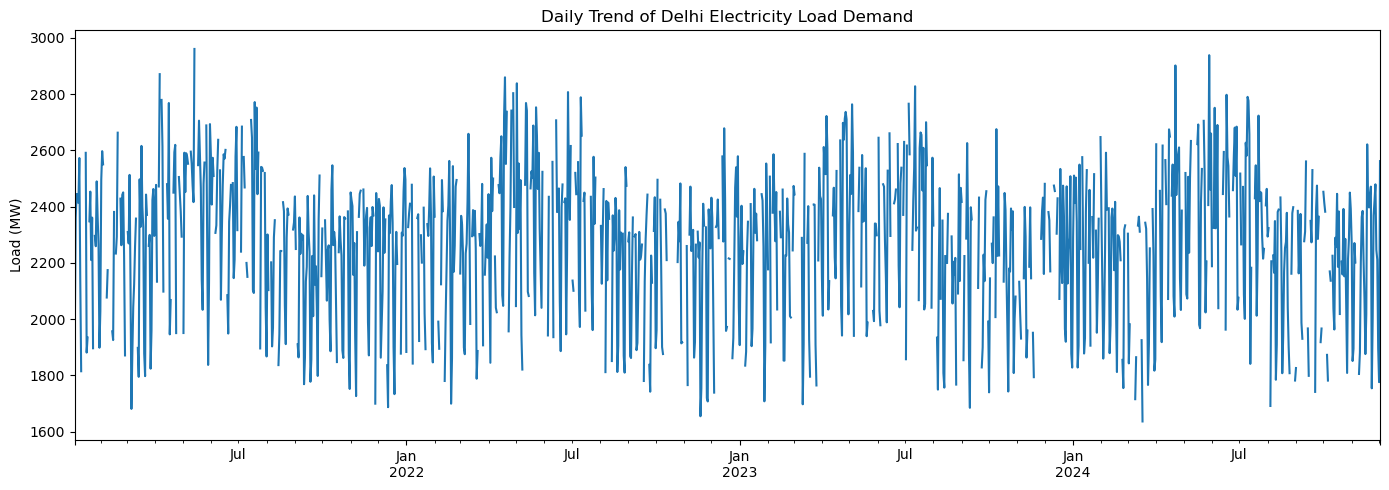

In [17]:
fig, my_canvas = plt.subplots(figsize=(14,5))
daily_data['Load'].plot(ax=my_canvas)
plt.title('Daily Trend of Delhi Electricity Load Demand')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.tight_layout()
plt.show()

### 6.2 Trend of Temperature

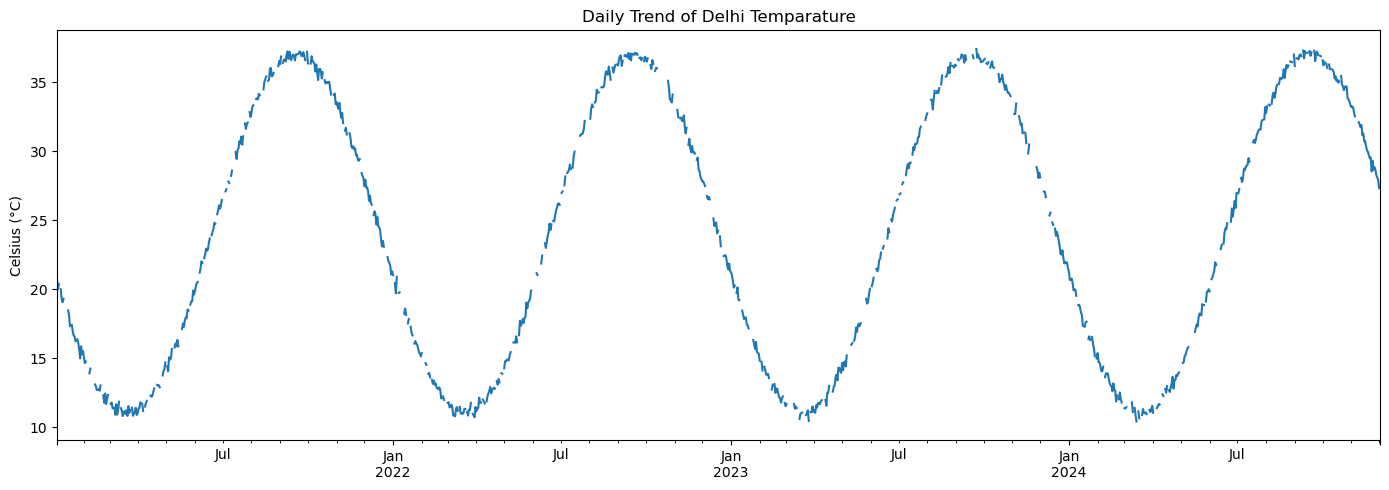

In [18]:
fig, my_canvas = plt.subplots(figsize=(14,5))
daily_data['temp'].plot(ax=my_canvas)
plt.title('Daily Trend of Delhi Temparature')
plt.xlabel(None)
plt.ylabel('Celsius (°C)')
plt.tight_layout()
plt.show()

### 6.3 Hourly Pattern in Load

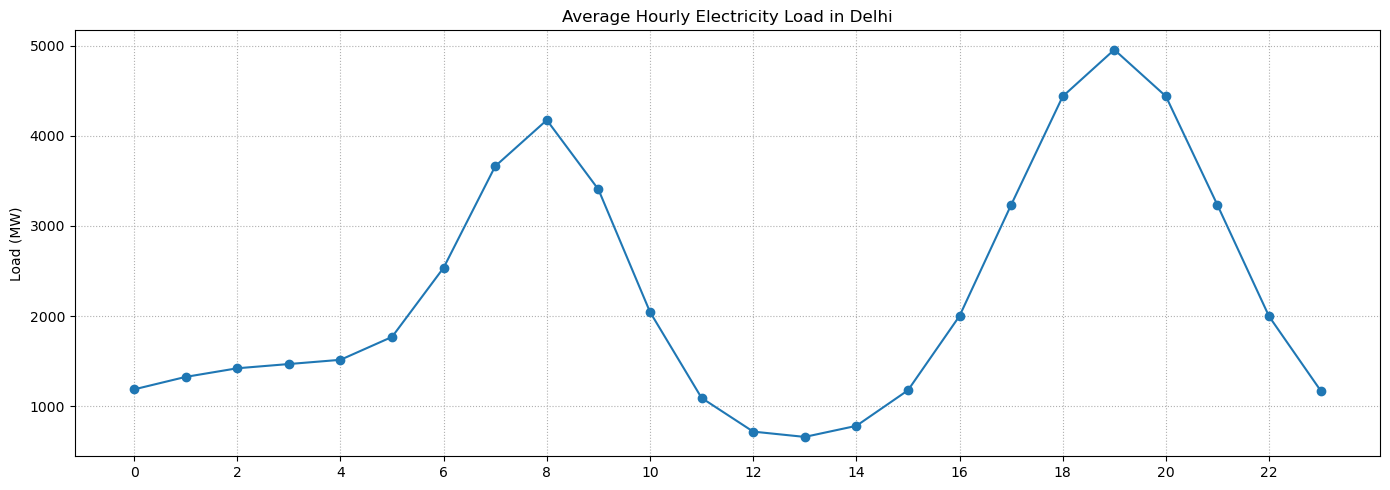

In [19]:
fig, my_canvas = plt.subplots(figsize=(14,5))
df.groupby('hour').agg({'Load':'mean'}).plot(ax=my_canvas, marker='o')
plt.title('Average Hourly Electricity Load in Delhi')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.legend().remove()
plt.grid(linestyle=':')
plt.xticks(np.arange(0,24,2))
plt.tight_layout()
plt.show()

### 6.4 Weekly Pattern in Load

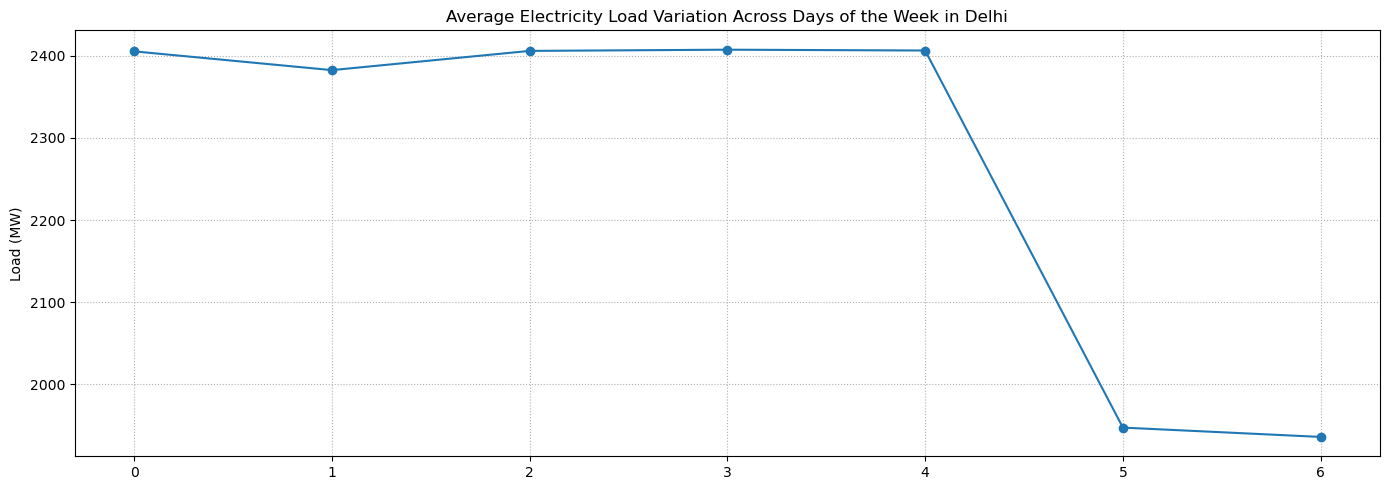

In [20]:
fig, my_canvas = plt.subplots(figsize=(14,5))
df.groupby('week').agg({'Load':'mean'}).plot(ax=my_canvas, marker='o')
plt.title('Average Electricity Load Variation Across Days of the Week in Delhi')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.legend().remove()
plt.grid(linestyle=':')
plt.xticks(np.arange(0,7,1))
plt.tight_layout()
plt.show()

### 6.5 Annual Pattern in Load

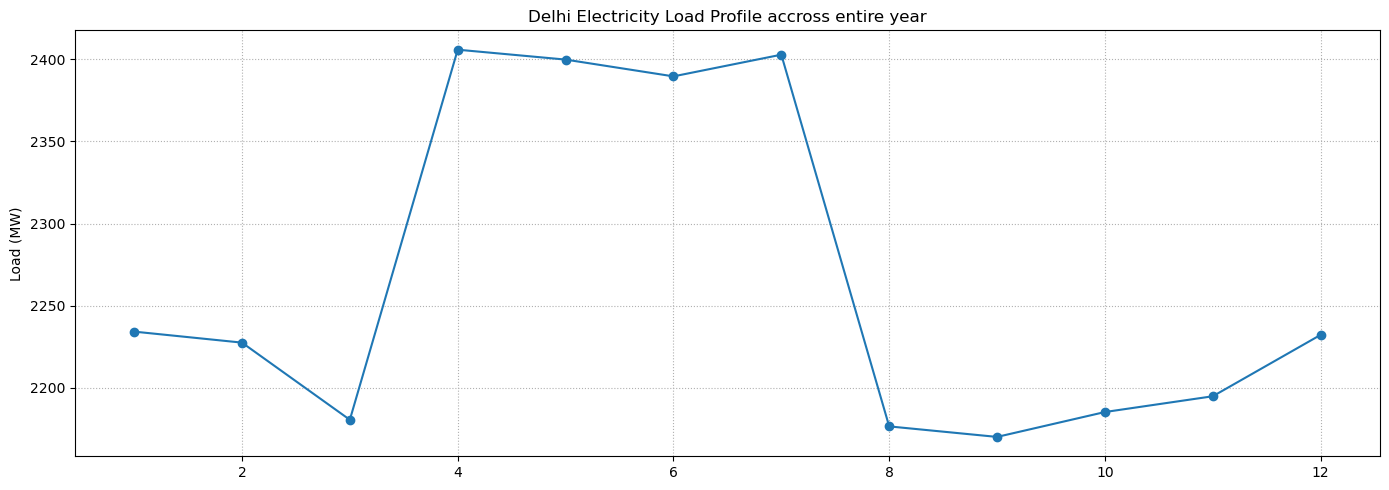

In [21]:
fig, my_canvas = plt.subplots(figsize=(14,5))
df.groupby('month').agg({'Load':'mean'}).plot(ax=my_canvas, marker='o')
plt.title('Delhi Electricity Load Profile accross entire year')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.legend().remove()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

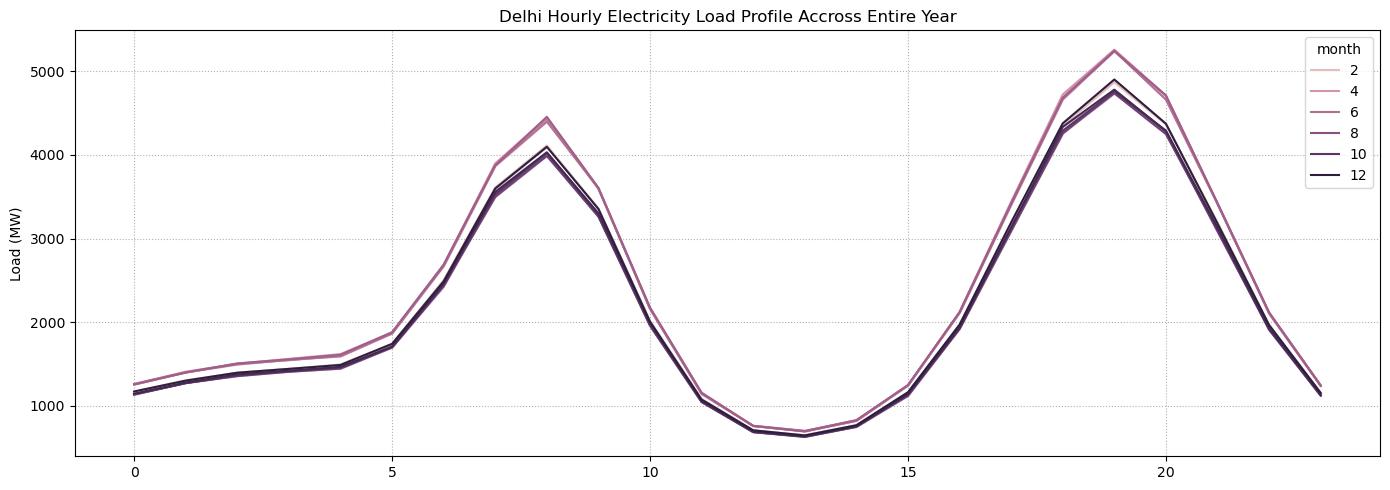

In [22]:
fig, my_canvas = plt.subplots(figsize=(14,5))
sns.lineplot(data=df, x='hour', y='Load', hue='month', estimator= 'mean', errorbar=('ci',0))
plt.title('Delhi Hourly Electricity Load Profile Accross Entire Year')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

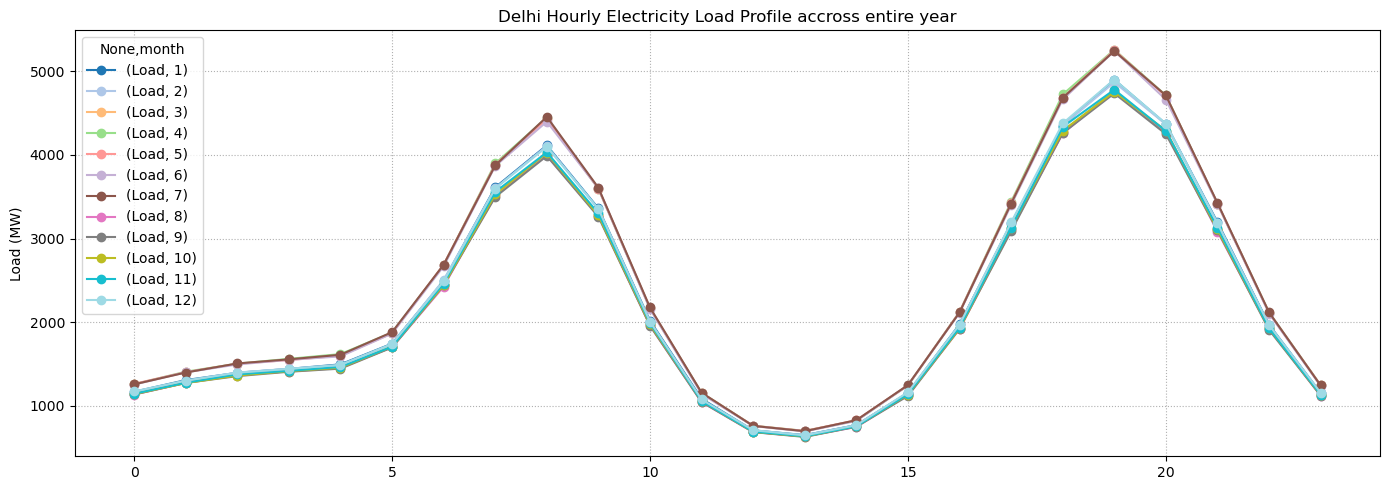

In [23]:
fig, my_canvas = plt.subplots(figsize=(14,5))
df.groupby(['month', 'hour']).agg({'Load':'mean'}).unstack(0).plot(ax=my_canvas, marker='o', colormap='tab20')
plt.title('Delhi Hourly Electricity Load Profile accross entire year')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

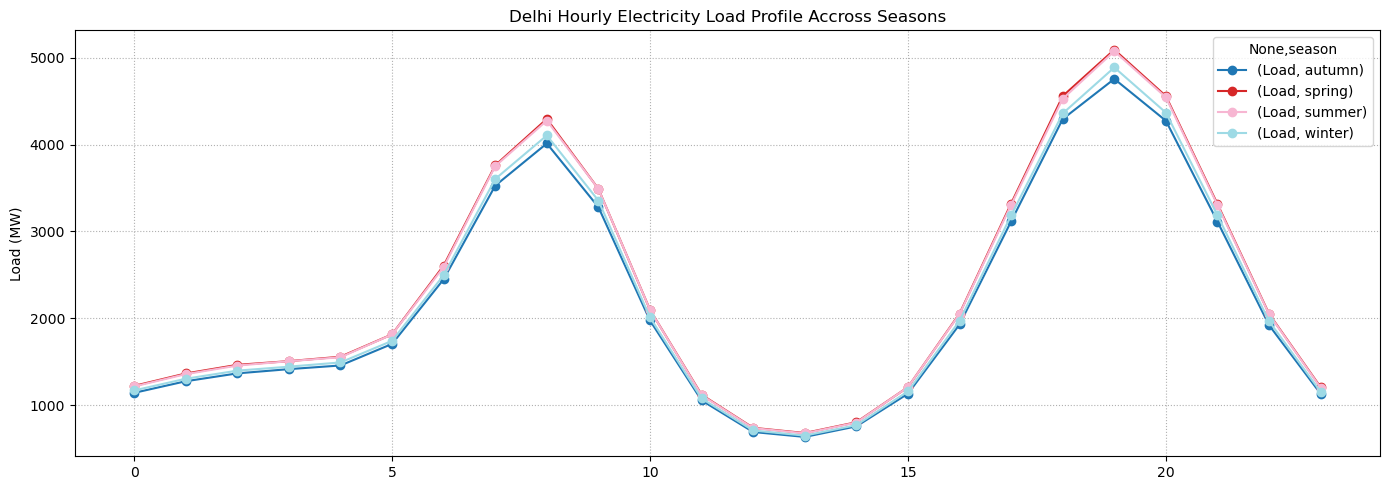

In [24]:
fig, my_canvas = plt.subplots(figsize=(14,5))
df.groupby(['season', 'hour']).agg({'Load':'mean'}).unstack(0).plot(ax=my_canvas, marker='o', colormap='tab20')
plt.title('Delhi Hourly Electricity Load Profile Accross Seasons')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

### 6.6 Annual Pattern in Temp

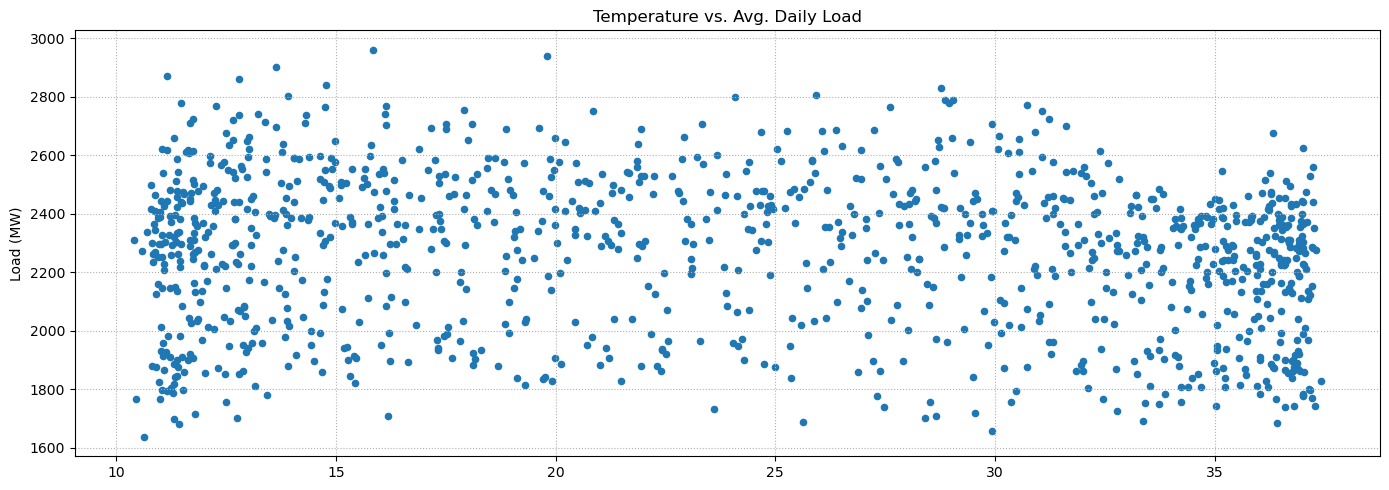

In [25]:
fig, my_canvas = plt.subplots(figsize=(14,5))
daily_data.plot(kind='scatter', ax=my_canvas, x='temp', y='Load')
plt.title('Temperature vs. Avg. Daily Load')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

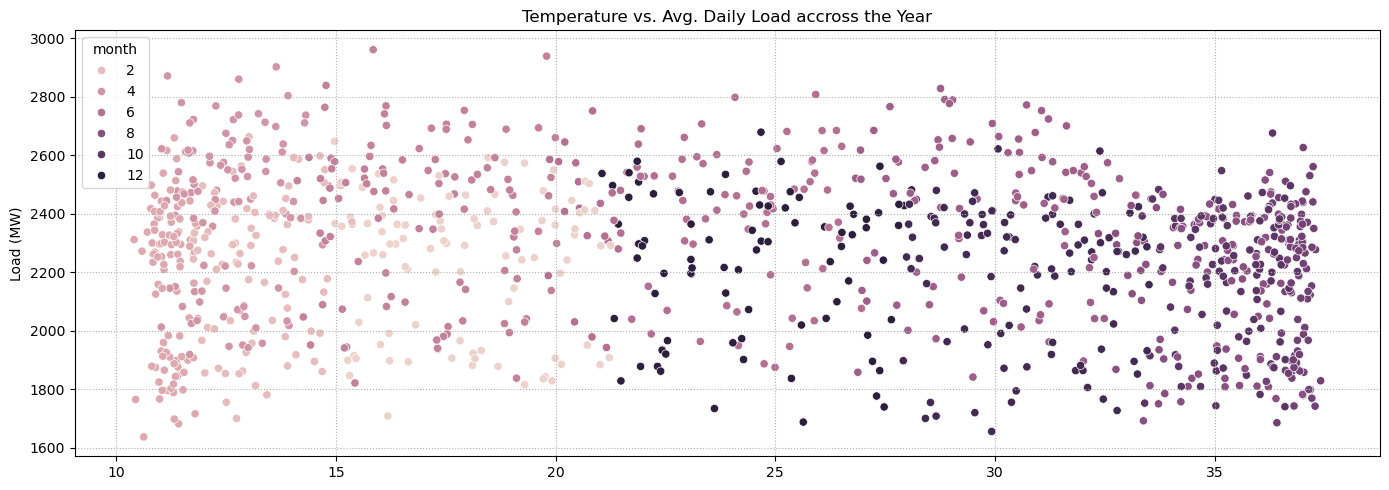

In [26]:
fig, my_canvas = plt.subplots(figsize=(14,5))
sns.scatterplot(data=daily_data, x='temp', y='Load', hue='month', ax=my_canvas)
plt.title('Temperature vs. Avg. Daily Load accross the Year')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

### 6.7 Correlation between Temp & Load

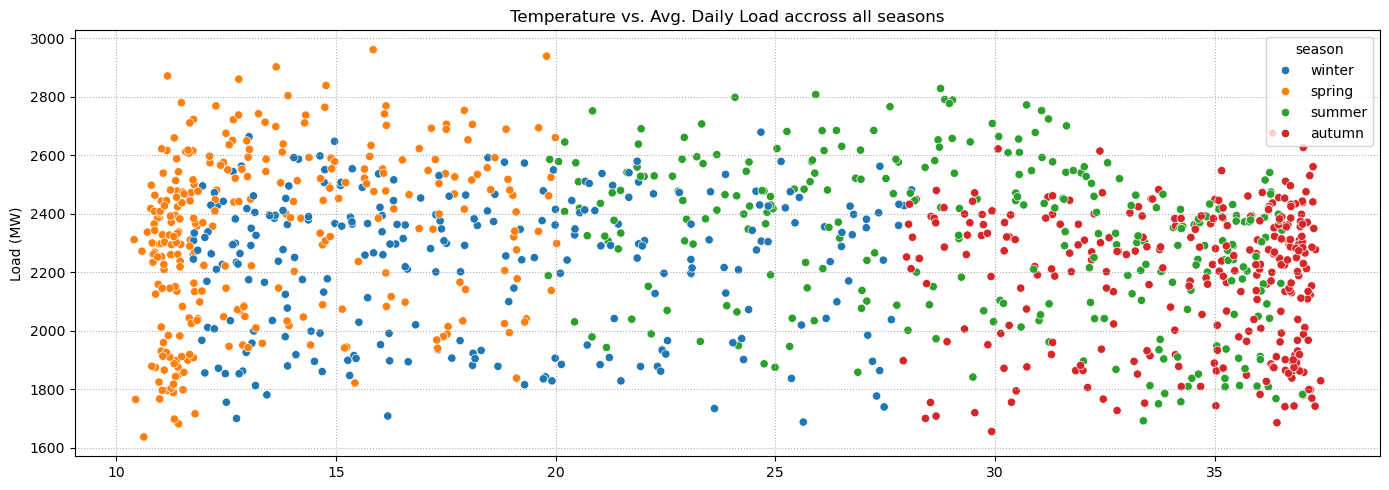

In [27]:
fig, my_canvas = plt.subplots(figsize=(14,5))
sns.scatterplot(data=daily_data, x='temp', y='Load', hue='season', ax=my_canvas)
plt.title('Temperature vs. Avg. Daily Load accross all seasons')
plt.xlabel(None)
plt.ylabel('Load (MW)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()